In [1]:
from BikeStationCDF import BikeStationCDF as BSCDF
from BikeStations import BikeStationNetwork as BSN
from BikeRelocationScheme import BikeRelocationScheme as BRS

from RouteAnalysis import RouteAnalysis

import traci
from sumolib import checkBinary

from Geometry import GeometryClass

import matplotlib.pyplot as plt
import numpy as np

In [2]:
traci.init(58890)
traci.setOrder(2)

In [3]:
myBikeNetwork = BSN()

In [4]:
RouteAnalysisSUMO = RouteAnalysis()

In [129]:
AllStationsIds = myBikeNetwork.getAllStationOnNetwork()
RelocationSchemes = BRS(AllStationsIds).getRebalancingWeights()

In [130]:
# Station = AllStationsIds[3]
# WkDay = 0
# RelocationSchemes[Station][WkDay][BRS.C_WEIGHTINDEX]

In [131]:
# myBikeNetwork.BikeStationsDict.keys()

In [132]:
# myBikeNetwork.getAllStationOnNetwork()

In [133]:
# dayItinerary[0][0][0] = 1000
#dayItinerary

In [134]:
BikeInitialStatus = [s.availableBikes() for s in list(myBikeNetwork.BikeStationsDict.values())]

In [135]:
def updateStatusOfStations(time, dayItinerary):
    for idx in range(len(dayItinerary)):
        for eventsStation in range(len(dayItinerary[idx])):
            # StationId retrived from trip timestamps of dayItinerary
            StationId = int(dayItinerary[idx][eventsStation][2])
            # Process events only when they're equal to time
            # times are represented in seconds, they need to be multiplied
            # by C_MINUTES_IN_HOUR
            if(int(dayItinerary[idx][eventsStation][0] * C_MINUTES_IN_HOUR) == time):
                # departure or arrival trip type
                tripInstance = dayItinerary[idx][eventsStation]
                
                if(tripInstance[1] == BSN.C_ARRIVALS_IDX):
                    if(myBikeNetwork.getBikeStationObject(
                            StationId).pushBike() is False):
                        # This should never be the case as the
                        # relocation occurs within the scope of
                        # push/removeBike()
                        print(myBikeNetwork.getBikeStationObject(                            
                            StationId).availableBikes())
                        raise

                else:
                    if(myBikeNetwork.getBikeStationObject(
                            StationId).removeBike() is False):
                        # This should never be the case as the
                        # relocation occurs within the scope of
                        # push/removeBike()
                        print(myBikeNetwork.getBikeStationObject(
                            StationId).availableBikes())
                        raise
    

In [136]:
def getNetworkRiskStatus(bikeNetwork):
    # StatusBike Network -> [StationId, NumberofAvailableBikes]
    StatusBikeNetwork = [[int(s), int(bikeNetwork.getBikeStationObject(s).availableBikes())]
        for s in bikeNetwork.BikeStationsDict.keys() ]
    
    data = np.array(StatusBikeNetwork)
    
    # Identify Risk Stations by applying a formula np.max/min +- 1 whcih has calculated empirically
    # to provide a mechanism for Risk Assesment. It's performance is out of the scope of this
    # module for now.
    
    #DockRiskStations -> Stations that have more bikes than docks
    DockRiskStations = data[(data[:,1] >= (np.max(data[:,1]) - 1)) & ((data[:,1]) > C_OPTIMAL_LEVEL)]
    
    #BikeRiskStations -> Stations that have more docks than bikes
    BikeRiskStations = data[(data[:,1] <= (np.min(data[:,1]) + 1)) & ((data[:,1]) < C_OPTIMAL_LEVEL)]

    return DockRiskStations, BikeRiskStations

In [137]:
def upcomingTrips(time, dayItinerary):
    dayUpcoming = []
    for s in range(len(dayItinerary)):
        UpcomingTrips_bool = ((dayItinerary[s][:,0]*60) >= time) & ((dayItinerary[s][:,0]*60) < (time + (0.125*60)))
        
        # dayUpcoming -> [[list(Trips timestamps)], [dayItinerary bool indexers for location of those trips],
        # dayItineraryIdx]
        if(dayItinerary[s][UpcomingTrips_bool].size > 0):
            dayUpcoming.append([ dayItinerary[s][UpcomingTrips_bool],  UpcomingTrips_bool, s])
            
    return dayUpcoming

In [138]:
def getDistanceBetweenStations(RouteAnalysisSUMO, stationIdEdge1, stationIdEdge2):
    p1 = [float(s) for s in RouteAnalysisSUMO.EdgetoEdgeCenter[stationIdEdge1]]
    p2 = [float(s) for s in RouteAnalysisSUMO.EdgetoEdgeCenter[stationIdEdge2]]
    
    return GeometryClass.getDistance(p1,p2)

In [139]:
def retrieveRiskMeasurements(BikeRiskStation, UpcomingInfo, myBikeNetwork, RouteAnalysisSUMO):
    NearStations = []
    UpcomingIdx = []
    for i, StationInfo in enumerate(UpcomingInfo):
        for j, trip in enumerate(StationInfo[0]):
            
            # Only departures will be analyzed by this function
            if((int(trip[1]) != BSN.C_ARRIVALS_IDX) & (int(trip[3]) in myBikeNetwork.getAllStationOnNetwork())):
                distance = \
                    getDistanceBetweenStations(
                        RouteAnalysisSUMO, 
                        myBikeNetwork.StationsOnNetwork.get(int(trip[3])), 
                        myBikeNetwork.StationsOnNetwork[BikeRiskStation])
                
                # 400 meters were choosen as per Singla study where this is the
                # maximum distance users where willing to change the
                # destination station
                if((distance < 400.0) & (distance > 5.0)):
                    NearStations.append(str(BikeRiskStation))
                    UpcomingIdx.append([i, j])
                    print(str(BikeRiskStation) + ' replaces: ' + str(int(trip[3])))
                    # print('One near station is: ' + str(int(trip[3])) + ' instead of: ' + str(RiskStation))
                    
    if(NearStations):
        # From all posible solutions, only the station with less bikes will be
        # selected as it is intended to avoid those stations to be empty
        RewardDestinationBikes =\
            [myBikeNetwork.getBikeStationObject(s).availableBikes() for s in NearStations]
        Idx = np.where(RewardDestinationBikes == np.min(RewardDestinationBikes))[0][0]
    
        return NearStations[Idx], UpcomingIdx
    
    else:
        return 0, 0

In [152]:
C_MINUTES_IN_HOUR = 60
C_HOURS_IN_DAY = 24
C_OPTIMAL_LEVEL = 10 # 10 bikes / 20 docks


dayItineraryObject = myBikeNetwork.getDayItinerary(0)
dayItinerary = []
for s in dayItineraryObject:
    dayItinerary.append(s.astype(object))

# for idx, _ in enumerate(dayItinerary):
#     print('Itinerary for Station: ' + str(dayItinerary[idx][0][2]))



myBikeNetwork.resetNetwork()
for time in range(C_MINUTES_IN_HOUR*C_HOURS_IN_DAY):
#     if(time % (C_MINUTES_IN_HOUR) == 0):
    if(time % (int(60 * 0.125)) == 0):
        
        # Get Most Critical Stations
        DockRiskStations, BikeRiskStations = getNetworkRiskStatus(myBikeNetwork)
        # Get the itinerary for the next time delta
        UpcomingInfo = upcomingTrips(time, dayItinerary)

        NearStation = 0
        UpcomingIdx = [0, 0]
        # print('\n\nIt ends ****************')
        # print('********************** It begins \n\n')
        for stationId in BikeRiskStations[:,0]:
            NearStation, UpcomingIdx =\
                retrieveRiskMeasurements(
                    stationId,
                    UpcomingInfo,
                    myBikeNetwork,
                    RouteAnalysisSUMO)
            if(NearStation != 0):
                NearStationObject = myBikeNetwork.getBikeStationObject(
                    int(NearStation))
                ProblemAssesment = C_OPTIMAL_LEVEL - NearStationObject.availableBikes()
                # ProblemAssesment = 1
                
                if((ProblemAssesment >= len(UpcomingIdx)) & (len(UpcomingInfo) > 0)):
                    for i, s in enumerate(UpcomingIdx):
                        # Index for the three required elements of UpcomingInfo
                        # Trip info, dayItineraryTripIndex and dayItineraryIdx
                        idx_1 = s[0]
                        # Index for the trips that are relevant within the UpcomingInfo
                        # element
                        idx_2 = s[1]
                        dayItineraryIdx = UpcomingInfo[idx_1][2]
                        dayItineraryStationIdx = UpcomingInfo[idx_1][1]
                        UpcomingTrips = UpcomingInfo[idx_1][0]
                        
                        # print('Test #1: ' + str(UpcomingInfo[idx_1][0]))
                        # print('Test #2: ' + str(dayItinerary[dayItineraryIdx]))
                        
                        for i, boolIdx in enumerate(dayItineraryStationIdx):
                            if(
                                (boolIdx == True) & \
                                ((dayItinerary[dayItineraryIdx][i][1]) != BSN.C_ARRIVALS_IDX) &\
                                (UpcomingInfo[idx_1][0][idx_2][3] == dayItinerary[dayItineraryIdx][i][3])):
                                
                                dayItinerary[dayItineraryIdx][i][3] = float(NearStation)
                                
                                
                        # print('Test #3: ' + str(dayItinerary[dayItineraryIdx])
                    
    
    # Update the Stations based on the dayItinerary provided / modified
    updateStatusOfStations(time,dayItinerary)
    
#     if(time % C_MINUTES_IN_HOUR == 0):
#         print('At time: ' + str(time) + ' minutes.') 
#         print('Dock Risk Stations: ')
#         print(DockRiskStations)
#         print('Bike Risk Stations: ')
#         print(BikeRiskStations)
#         print()


57 replaces: 55
51 replaces: 62
51 replaces: 61
51 replaces: 50
28 replaces: 10
58 replaces: 59
29 replaces: 28
29 replaces: 34
57 replaces: 55
58 replaces: 77
57 replaces: 55
25 replaces: 38
25 replaces: 39
58 replaces: 54
57 replaces: 54
25 replaces: 12
29 replaces: 28
38 replaces: 50
38 replaces: 37
78 replaces: 77
78 replaces: 58
57 replaces: 58
58 replaces: 59
51 replaces: 52
51 replaces: 61
51 replaces: 50
58 replaces: 57
78 replaces: 57
78 replaces: 57
62 replaces: 51
51 replaces: 60
51 replaces: 52
11 replaces: 10
11 replaces: 10
11 replaces: 27
62 replaces: 51
62 replaces: 51
51 replaces: 62
58 replaces: 59
58 replaces: 78
58 replaces: 57
58 replaces: 57
62 replaces: 61
25 replaces: 12
74 replaces: 75
61 replaces: 75
61 replaces: 76
51 replaces: 50
51 replaces: 50
38 replaces: 50
38 replaces: 50
38 replaces: 25
38 replaces: 37
2 replaces: 9
61 replaces: 74
62 replaces: 74
61 replaces: 75
61 replaces: 62
61 replaces: 74
51 replaces: 62
62 replaces: 61
51 replaces: 61
61 replace

In [141]:
#Relocation events on every station
print([ (s, myBikeNetwork.getBikeStationObject(s).getStationStats()[0]) for s in myBikeNetwork.BikeStationsDict.keys() ])

[('2', 6), ('9', 4), ('80', 3), ('81', 2), ('77', 1), ('75', 7), ('78', 6), ('74', 2), ('76', 0), ('58', 9), ('61', 3), ('59', 2), ('60', 0), ('57', 0), ('62', 3), ('53', 5), ('50', 2), ('51', 12), ('54', 6), ('56', 3), ('55', 2), ('52', 4), ('38', 2), ('36', 0), ('37', 2), ('34', 5), ('35', 3), ('39', 3), ('26', 1), ('25', 0), ('31', 1), ('29', 1), ('27', 3), ('28', 10), ('8', 2), ('6', 0), ('12', 6), ('10', 3), ('11', 8)]


In [142]:
C_BIKESTATION = 2

currentBikeStation =\
    myBikeNetwork.getBikeStationObject(C_BIKESTATION)
print(currentBikeStation)

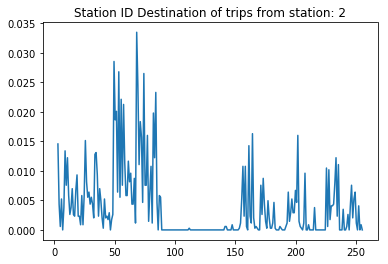

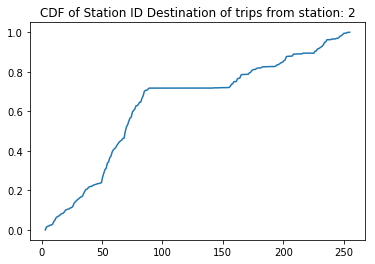

In [143]:
destinations = \
    list(
    currentBikeStation\
    .stationCDFDepartures\
    .wkDayDepartures[0]\
    .Destino_Id)
hist, bin_edges = \
    np.histogram(
        destinations, bins=np.max(destinations),
        density=True)

hist = np.append(hist, [0.0])
plt.figure(1)
plt.title('Station ID Destination of trips from station: ' + str(C_BIKESTATION))
plt.plot(bin_edges, hist)
plt.figure(2)
plt.title('CDF of Station ID Destination of trips from station: ' + str(C_BIKESTATION))
plt.plot(bin_edges, BSCDF.computeCDF(hist,bin_edges))



In [144]:
C_NUMBER_OF_TRIPS = 50
C_WEEKDAY = 5

Arrivals = np.empty(0)
Departures = np.empty(0)
for i in range(C_NUMBER_OF_TRIPS):
    BikeStationTrips = \
        currentBikeStation.getTripsOnWeekday(C_WEEKDAY)

    tArrivals =\
        BikeStationTrips[
            BikeStationTrips[:, 1] ==
            BSN.C_ARRIVALS_IDX]
    Arrivals = np.r_[Arrivals, tArrivals[:,0]]


    tDepartures =\
        BikeStationTrips[
            BikeStationTrips[:, 1] == 
            BSN.C_DEPARTURES_IDX]
    Departures = np.r_[Departures, tDepartures[:,0]]


In [145]:
BikeStationTrips

array([[ 7.25 ,  1.   ],
       [ 7.25 ,  1.   ],
       [ 7.375,  1.   ],
       [ 7.5  ,  0.   ],
       [ 7.625,  1.   ],
       [ 8.   ,  0.   ],
       [ 8.125,  1.   ],
       [ 8.5  ,  1.   ],
       [ 8.5  ,  1.   ],
       [ 8.5  ,  0.   ],
       [ 8.625,  1.   ],
       [ 8.75 ,  0.   ],
       [ 8.75 ,  0.   ],
       [ 8.75 ,  0.   ],
       [ 8.75 ,  0.   ],
       [ 8.875,  1.   ],
       [ 8.875,  0.   ],
       [ 9.   ,  0.   ],
       [ 9.   ,  0.   ],
       [ 9.25 ,  1.   ],
       [ 9.5  ,  1.   ],
       [ 9.75 ,  1.   ],
       [10.125,  0.   ],
       [10.125,  0.   ],
       [10.75 ,  0.   ],
       [11.125,  0.   ],
       [11.25 ,  1.   ],
       [11.75 ,  0.   ],
       [12.125,  1.   ],
       [12.375,  1.   ],
       [12.625,  1.   ],
       [12.625,  0.   ],
       [12.75 ,  1.   ],
       [12.875,  1.   ],
       [12.875,  1.   ],
       [12.875,  0.   ],
       [13.   ,  1.   ],
       [13.125,  1.   ],
       [13.25 ,  1.   ],
       [13.25 ,  0.   ],


14.258272800645681
14.48955722639933


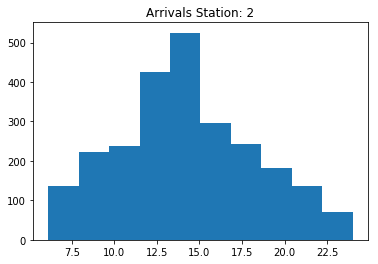

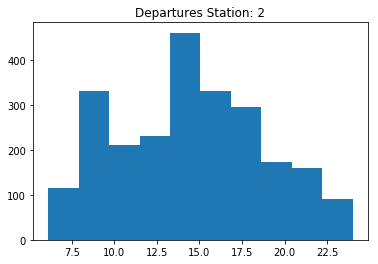

In [146]:
plt.figure(1)
plt.title('Arrivals Station: ' + 
    currentBikeStation.getStationId())
plt.hist(Arrivals)
print(np.mean(Arrivals))

plt.figure(2)
plt.title(
    'Departures Station: ' + 
    currentBikeStation.getStationId())
plt.hist(Departures)
print(np.mean(Departures))

In [147]:
ahist, abin_edges = \
    np.histogram(
        Arrivals, bins=24 * 8,
        density=True,
        range=(0.0, 24.0))
ahist = np.append(ahist, [0.0])

In [148]:
dhist, dbin_edges = \
    np.histogram(
        Departures, bins=24 * 8,
        density=True,
        range=(0.0, 24.0))
dhist = np.append(dhist, [0.0])

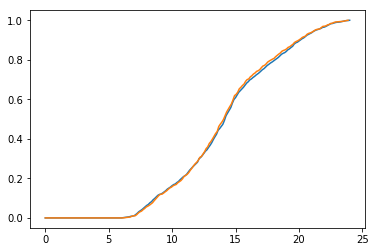

In [149]:
x =\
currentBikeStation.stationCDFArrivals\
.wkDayDepartures_cdf[C_WEEKDAY][0]

y =\
currentBikeStation.stationCDFArrivals\
.wkDayDepartures_cdf[C_WEEKDAY][1]

acdf = BSCDF.computeCDF(
            ahist,abin_edges)

plt.plot(x/3600,y)
plt.plot(24.0*np.arange(len(acdf))/len(acdf), acdf)

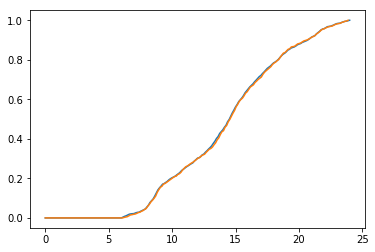

In [150]:
x =\
currentBikeStation.stationCDFDepartures\
.wkDayDepartures_cdf[C_WEEKDAY][0]

y =\
currentBikeStation.stationCDFDepartures\
.wkDayDepartures_cdf[C_WEEKDAY][1]

dcdf = BSCDF.computeCDF(
            dhist,dbin_edges)

plt.plot(x/3600,y)
plt.plot(24.0*np.arange(len(dcdf))/len(dcdf), dcdf)